<a href="https://colab.research.google.com/github/bGuom/RideFare-Classification-Machine-Learning/blob/master/RideFare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RideFare description

Training dataset consists of a sample tuk rides completed. Nearly 10% of the fares are incorrect. The aim should be to train a model based on the given dataset and predict whether the fare of a new set of trips is correct or not.

Submissions will be evaluated based on their macro F1 score

For each tripId in the test set, you must predict whether the fare is correct (1) or incorrect(0)

Kaggle Link

https://www.kaggle.com/c/fare-classification

# Imports

In [1]:
!pip install catboost

In [2]:
#Import pandas like:
import pandas as pd

#Import numpy like:
import numpy as np

#Import matplotlib 
import matplotlib.pyplot as plt

#Import math
import math

#Import SKLearn 
import sklearn 

#Import imputer
from sklearn.impute import SimpleImputer

#Import Sclaer
from sklearn.preprocessing import MinMaxScaler

#Import Splitter
from sklearn.model_selection import train_test_split

#Import models
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv

#imoport evaluation scores
from sklearn.metrics import accuracy_score


# Load data from file

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/bGuom/RideFare-Classification-Machine-Learning/master/train_.csv')
df.head()  #Display the first 5 rows 

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,7.801,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,5.211,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,9.637,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,1.880,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,9.998,358.39,correct


#Getting to know the Data Frame

In [4]:
df.shape

(17176, 15)

In [5]:
df.columns

Index(['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pickup_time',
       'drop_time', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'distance',
       'fare', 'label'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  distance                   17176 non-null  float64
 13  fare                       17039 non-null  flo

In [7]:
#Drop Null
df = df.dropna()

In [8]:
# Independent Variables

X = df.iloc[:,:-1]
X.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,7.801,270.32
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,5.211,197.85
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,9.637,301.64
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,1.880,82.30
5,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,31.163,1065.02


In [9]:
# Dependent Variables

Y = df.iloc[:,-1:]
Y.head()

,label
0,correct
1,correct
2,correct
3,correct
5,correct


# Flagging Missing Values - Not used in the best score

Add new column and flag whether the row has nan or not

In [10]:
#X['notNull'] =  [1 if x == False else 0 for x in  df.isnull().any(axis=1)]
#X.head() 

# Handling missing values - Not used in the best score


## Replace Missing value with 0

In [11]:
#X = X.fillna(0)
#X.info()

## Replace Nan values with mean/median of the column

In [12]:
#imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [13]:
#imputer = imputer.fit(X.iloc[:,1:6])
#X.iloc[:,1:6] = imputer.transform(X.iloc[:,1:6])
#X.head()

In [14]:
#imputer = imputer.fit(X.iloc[:,-2:])
#X.iloc[:,-2:] = imputer.transform(X.iloc[:,-2:])
#X.head()

In [15]:
#X.info()

# Data Cleaning

## Removing tripid column 

In [16]:
X = X.drop('tripid',1)
X.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'distance', 'fare'],
      dtype='object')

In [17]:
X.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,7.801,270.32
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,5.211,197.85
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,9.637,301.64
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,1.880,82.30
5,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,31.163,1065.02


## Understanding about the Location data

/usr/local/lib/python3.6/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


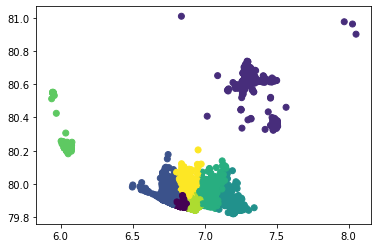

In [18]:
from scipy.cluster.vq import kmeans2, whiten

coordinates= X.iloc[:,7:9].values
a, b = kmeans2(whiten(coordinates), 10, iter = 20)  
plt.scatter(coordinates[:,0], coordinates[:,1], c=b);
plt.show()

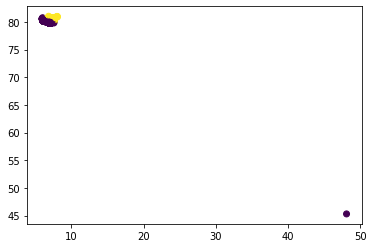

In [19]:
from scipy.cluster.vq import kmeans2, whiten

coordinates= X.iloc[:,9:11].values
a, b = kmeans2(whiten(coordinates), 2, iter = 20)  
plt.scatter(coordinates[:,0], coordinates[:,1], c=b);
plt.show()

## Calculating displacement based on Pickup & Drop location

This part was not used as I used and HereMaps API to get distance between pickup location and drop location and added to the data frame

In [20]:
def getDistance(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
  
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [21]:
#displacements = getDistance(X.pick_lat,X.pick_lon,X.drop_lat,X.drop_lon)
#X['displacement'] = displacements
#X.head()

In [22]:
X.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,7.801,270.32
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,5.211,197.85
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,9.637,301.64
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,1.880,82.30
5,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,31.163,1065.02


## Convert Label into 0 - Incorrect , 1 - Correct

In [23]:
Y['label'].value_counts()

correct      15442
incorrect     1526
Name: label, dtype: int64

In [24]:
Y['label'] = [1 if x == 'correct' else 0 for x in Y['label']]

In [25]:
Y['label'].value_counts()

1    15442
0     1526
Name: label, dtype: int64

#OutLier New Column - Not Used in the best score

Check outliers and add new column to indicate whether the row contain an outlier or not

In [26]:
def plot_histogram(x):
    plt.hist(x, color='gray', alpha=0.5)
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

In [27]:
def find_outliers(x):
    q1 = np.percentile(x, 1)
    q3 = np.percentile(x, 99)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices

def find_valids(x):
    q1 = np.percentile(x, 1)
    q3 = np.percentile(x, 99)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    valid_indices = list(x.index[(x >= floor)|(x <= ceiling)])

    return valid_indices

In [28]:
#notOutlier = [1] * X.shape[0]

In [29]:
def fix_outliers(x):
  for k in find_outliers(x):
    notOutlier[k] = 0

In [30]:
features = ['fare','additional_fare','duration','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup']

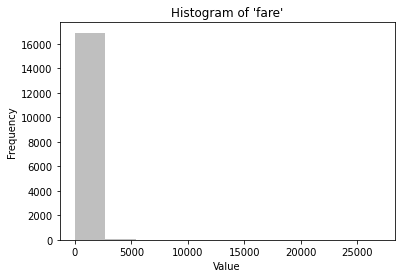

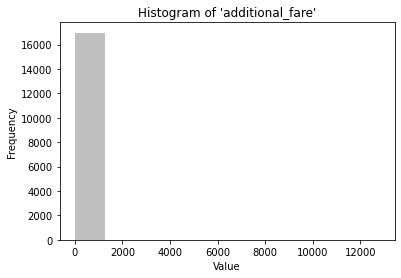

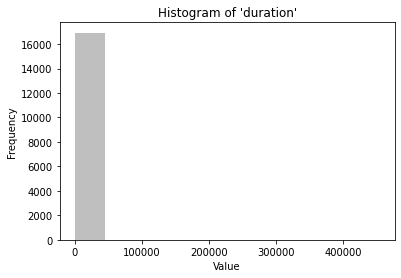

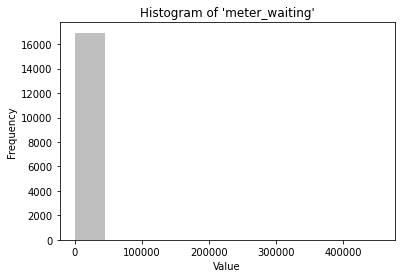

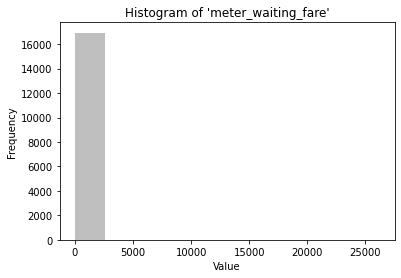

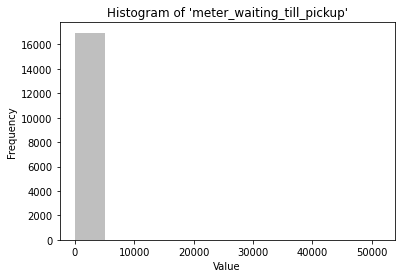

In [31]:
for feature in features:
  plot_histogram(X[feature])

Flag outlier rows

In [32]:
#for feature in features:
  #fix_outliers(X[feature])

In [33]:
#X['notOutlier'] = notOutlier

In [34]:
#X['notOutlier'].value_counts()

#OutLier Fix - Not Used in the best Score

Replace outliers with mean

In [35]:
def remove_outliers(x):
    mid = np.mean(x[find_valids(x)])
    x[find_outliers(x)] = mid

In [36]:
#for feature in features:
  #remove_outliers(X[feature])

In [37]:

X_saved = X
X_saved.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,7.801,270.32
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,5.211,197.85
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,9.637,301.64
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,1.880,82.30
5,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,31.163,1065.02


# Feature Scaling - Not Used in the best Score

In [38]:

min_max_scaler = MinMaxScaler()

def scaled(x):
    x_scaled = pd.DataFrame(min_max_scaler.fit_transform(x.values.reshape(-1,1)))
    return x_scaled


In [39]:
#X['fare'] = (scaled(X['fare']))

#X['distance'] = (scaled(X['distance']))

#X['meter_waiting_till_pickup'] = (scaled(X['meter_waiting_till_pickup']))

#X['meter_waiting_fare'] = (scaled(X['meter_waiting_fare']))

#X['meter_waiting'] = (scaled(X['meter_waiting']))

#X['duration'] = (scaled(X['duration']))

#X['additional_fare'] = (scaled(X['additional_fare']))

In [40]:
X.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,7.801,270.32
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,5.211,197.85
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,9.637,301.64
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,1.880,82.30
5,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,31.163,1065.02


# New Features

## Add pickup hour and drop hour

In [41]:
X['pick_up_h'] = [int(d.split(' ')[1].split(':')[0]) for d in X['pickup_time']]
X['drop_h'] = [int(d.split(' ')[1].split(':')[0]) for d in X['drop_time']]
X = X.drop(['pickup_time','drop_time'], axis = 1)

## Adding Fare per trip duraion

In [42]:
X['fare_per_min'] = (X['fare'] / abs(X['duration'] +1 - X['meter_waiting']))*60

In [43]:
X.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare,pick_up_h,drop_h,fare_per_min
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,7.801,270.32,0,0,20.820539
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,5.211,197.85,0,1,15.934228
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,9.637,301.64,1,1,17.954762
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,1.880,82.30,2,2,15.054878
5,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,31.163,1065.02,5,6,19.808184


## Convert Lat Lon to Radien

In [44]:
def deg_to_rad(dr):
    return (dr*math.pi)/180

X['pick_lat'] = deg_to_rad(X['pick_lat'])
X['pick_lon'] = deg_to_rad(X['pick_lon'])
X['drop_lat'] = deg_to_rad(X['drop_lat'])
X['drop_lon'] = deg_to_rad(X['drop_lon'])

In [45]:
X.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare,pick_up_h,drop_h,fare_per_min
0,10.5,834.0,56.0,0.0000,64.0,0.119774,1.394506,0.120485,1.394139,7.801,270.32,0,0,20.820539
1,10.5,791.0,47.0,0.0000,134.0,0.120181,1.394490,0.120667,1.394384,5.211,197.85,0,1,15.934228
2,10.5,1087.0,80.0,0.0000,61.0,0.120574,1.393909,0.121068,1.394773,9.637,301.64,1,1,17.954762
3,10.5,598.0,271.0,15.6638,68.0,0.120876,1.394335,0.120907,1.394467,1.880,82.30,2,2,15.054878
5,10.5,3407.0,182.0,0.0000,112.0,0.124512,1.394464,0.120753,1.393905,31.163,1065.02,5,6,19.808184


## Add sped feature 

In [46]:
X['speed'] = (X['distance'] / abs(X['duration'] +1 - X['meter_waiting']))*60

# Model Building

Split the model

In [47]:

x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.75,random_state=1)

In [48]:
print(df.shape)
print(X.shape)

(16968, 15)
(16968, 15)


## Random Forest - Not used for the best score

 Create the model & Fit on training data
(n_estimators=5000,n_jobs=-1,max_features=9)

In [49]:
#model = RandomForestClassifier(n_estimators=5000,max_features=9,criterion='gini', max_depth=None, bootstrap=True, n_jobs=-1 )
#model.fit(x_train, y_train)

## CatBoot - Used for the best score

In [50]:
model = CatBoostClassifier(
    task_type="GPU",
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'

)

model.fit(
    X, Y,
    eval_set=(x_test, y_test),
    #logging_level='Verbose',
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Cross Validation

In [51]:
#cv_params = model.get_params()
#cv_params.update({
#    'loss_function': 'Logloss'
#})
#cv_data = cv(
#    Pool(X, Y),
#    cv_params,
#    plot=True
#)

#print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precise validation accuracy score: 0.9584509617507164


## F1 Score

In [52]:
from sklearn.metrics import f1_score
y_pred = model.predict(x_test)
cat_score = f1_score(y_test, y_pred)
print("Catboost F1 score = {}".format(f1_score(y_test, y_pred)))

Catboost F1 score = 0.9855517197289348


## Feature Importance

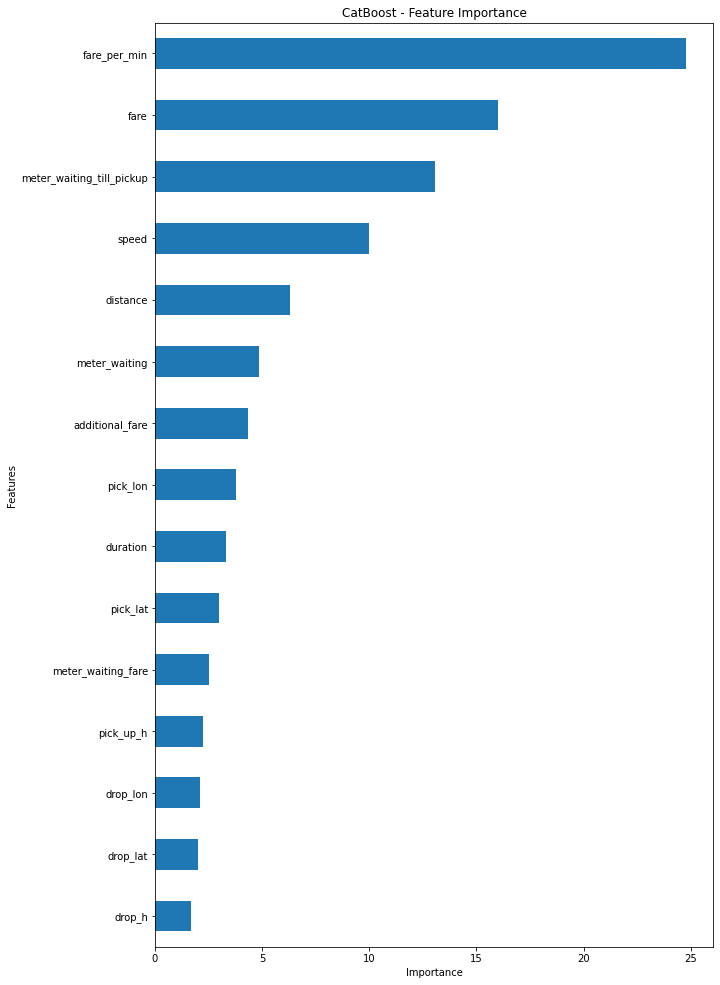

In [54]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 17), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

# TEST SECTION

In [ ]:
tdf = pd.read_csv('https://raw.githubusercontent.com/bGuom/RideFare-Classification-Machine-Learning/master/test_.csv')
tdf.head()  #Display the first 5 rows 

In [ ]:
id_col = tdf.iloc[:,0]
id_col

In [ ]:
#tdf['notNull'] =  [1 if x == False else 0 for x in  tdf.isnull().any(axis=1)]
#tdf.head() 

In [ ]:
#tdf = tdf.fillna(0)
#tdf.info()

Following are the replaced method

In [ ]:
#imputer = SimpleImputer(missing_values=np.nan, strategy='median')
#imputer = imputer.fit(tdf.iloc[:,1:6])
#tdf.iloc[:,1:6] = imputer.transform(tdf.iloc[:,1:6])
#imputer = imputer.fit(tdf.iloc[:,-2:])
#tdf.iloc[:,-2:] = imputer.transform(tdf.iloc[:,-2:])

In [ ]:
tdf = tdf.drop('tripid',1)

In [ ]:
def getDistance(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
  
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [ ]:
#displacements = getDistance(tdf.pick_lat,tdf.pick_lon,tdf.drop_lat,tdf.drop_lon)
#tdf['displacement'] = displacements

In [ ]:
tdf.columns

In [ ]:
tdf.head()

In [ ]:
#tnotOutlier = [1] * tdf.shape[0]

In [ ]:
def t_fix_outliers(x):
  for k in find_outliers(x):
    tnotOutlier[k] = 0

In [ ]:
#t_fix_outliers(tdf['fare'])
#t_fix_outliers(tdf['duration'])
#t_fix_outliers(tdf['additional_fare'])
#t_fix_outliers(tdf['meter_waiting'])
#t_fix_outliers(tdf['meter_waiting_fare'])
#t_fix_outliers(tdf['meter_waiting_till_pickup'])
#tdf['notOutlier'] = tnotOutlier

In [ ]:
#tdf['notOutlier'].value_counts()

In [ ]:
def t_remove_outliers(x):
    mid = np.mean(x[find_valids(x)])
    x[find_outliers(x)] = mid

In [ ]:
#t_remove_outliers(tdf['fare'])
#t_remove_outliers(tdf['duration'])
#t_remove_outliers(tdf['additional_fare'])
#t_remove_outliers(tdf['meter_waiting'])
#t_remove_outliers(tdf['meter_waiting_fare'])
#t_remove_outliers(tdf['meter_waiting_till_pickup'])

In [ ]:
#min_max_scaler = MinMaxScaler()

def t_scaled(x):
    x_scaled = pd.DataFrame(min_max_scaler.fit_transform(x.values.reshape(-1,1)))
    return x_scaled


In [ ]:
#tdf['fare'] = (t_scaled(tdf['fare']))

#tdf['distance'] = (t_scaled(tdf['distance']))

#tdf['meter_waiting_till_pickup'] = (t_scaled(tdf['meter_waiting_till_pickup']))

#tdf['meter_waiting_fare'] = (t_scaled(tdf['meter_waiting_fare']))

#tdf['meter_waiting'] = (t_scaled(tdf['meter_waiting']))

#tdf['duration'] = (t_scaled(tdf['duration']))

#tdf['additional_fare'] = (t_scaled(tdf['additional_fare']))

In [ ]:
tdf['fare_per_min'] = (tdf['fare'] / abs(tdf['duration'] +1 - tdf['meter_waiting']))*60

In [ ]:
def deg_to_rad(dr):
    return (dr*math.pi)/180

tdf['pick_lat'] = deg_to_rad(tdf['pick_lat'])
tdf['pick_lon'] = deg_to_rad(tdf['pick_lon'])
tdf['drop_lat'] = deg_to_rad(tdf['drop_lat'])
tdf['drop_lon'] = deg_to_rad(tdf['drop_lon'])

In [ ]:
tdf['speed'] = (tdf['distance'] / abs(tdf['duration'] +1 - tdf['meter_waiting']))*60

In [ ]:
tdf.tail()

In [ ]:
test_prediction = model.predict(tdf)
test_prediction

In [ ]:
out_df = pd.DataFrame(id_col.values, columns=['tripid'])
out_df['prediction'] = test_prediction

In [ ]:
out_df

In [ ]:
out_df['prediction'].value_counts()

In [ ]:
out_df.to_csv(r'results_catboost_speed.csv', index = False)